In [ ]:
"""EEGNet - Motor Imagery Classification (Hands vs Feet) - 50 Subjects"""

!pip install mne

import mne
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, DepthwiseConv2D, LSTM, Dense,
                                     Dropout, BatchNormalization, Activation,
                                     Reshape, Flatten, AveragePooling1D, Conv2D, SeparableConv2D, AveragePooling2D)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json
from collections import Counter
import pandas as pd

In [ ]:

SUBJECT_IDS = range(1, 101)
RUNS = [5, 9, 13]        
FS = 160                  
T_MIN = 0.5              
T_MAX = 6.0
EPOCH_LENGTH = int((T_MAX - T_MIN) * FS) + 1  

print(f"🎯 Target: Hands vs Feet")
print(f"⏱️ Expected Timepoints: {EPOCH_LENGTH}")

🎯 Target: Hands vs Feet
⏱️ Expected Timepoints: 881


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Data berhasil dimuat dan digabung.
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info |

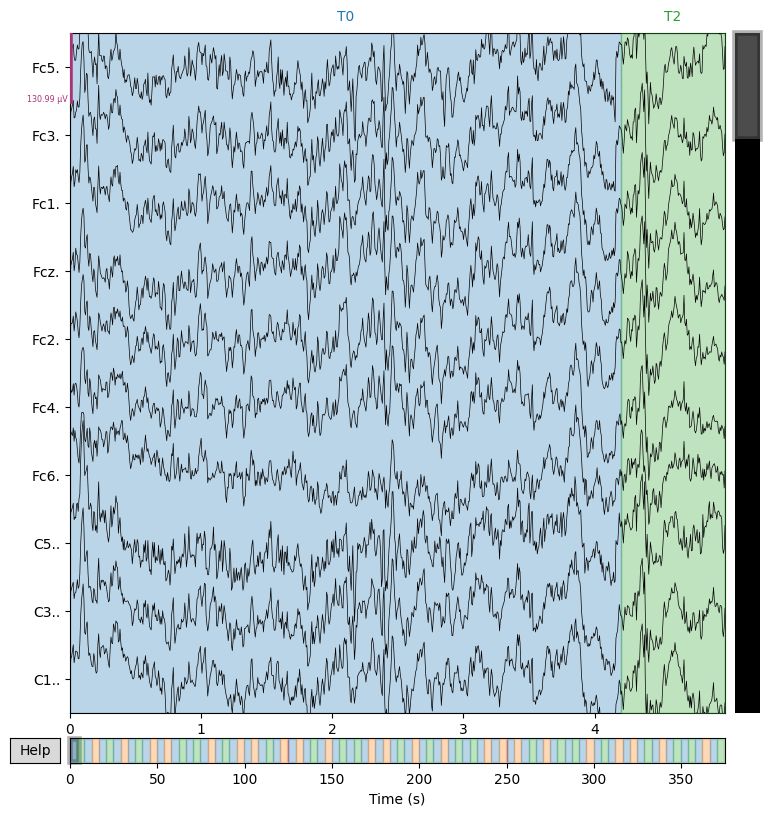

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
--- Informasi Label (Events) ---
Event ID (Label ke Angka):
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [39]:
subject_id = 1
runs = [5, 9, 13]

fnames = mne.datasets.eegbci.load_data(subject_id, runs)

raws = [mne.io.read_raw_edf(f, preload=True) for f in fnames]
raw = mne.io.concatenate_raws(raws)

print("Data berhasil dimuat dan digabung.")

print(raw.info)

sampling_rate = raw.info['sfreq']
n_channels = raw.info['nchan']
channel_names = raw.info['ch_names']

print(f"--- Informasi Struktur Data ---")
print(f"1. Sampling Rate: {sampling_rate} Hz")
print(f"2. Jumlah Channel: {n_channels}")
print(f"3. Daftar Nama Channel (contoh 5 pertama): {channel_names[:5]}")
print(f"4. Format Data Mentah: Data dimuat dari file .edf")
print(f"   Total Durasi Data: {raw.times.max():.2f} detik")

raw.plot(duration=5, n_channels=10, scalings='auto', title='Contoh Sinyal EEG Mentah')

events, event_id = mne.events_from_annotations(raw)

print("--- Informasi Label (Events) ---")
print("Event ID (Label ke Angka):")
print(event_id)


Total events ditemukan: 90
Bentuk array events (sample_index, 0, event_code):
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]

--- Distribusi Label Kelas ---
Label: T0 (Kode: 1) 	-> Jumlah Trials: 45
Label: T2 (Kode: 3) 	-> Jumlah Trials: 22
Label: T1 (Kode: 2) 	-> Jumlah Trials: 23


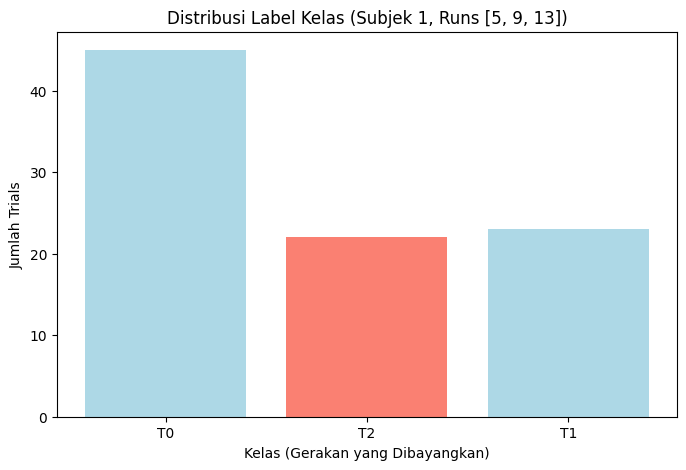

In [40]:
print(f"\nTotal events ditemukan: {len(events)}")
print("Bentuk array events (sample_index, 0, event_code):")
print(events[:5])

event_codes = events[:, 2]

event_counts = Counter(event_codes)

labels_map = {v: k for k, v in event_id.items()}

print("\n--- Distribusi Label Kelas ---")
for code, count in event_counts.items():
    if code in labels_map:
        print(f"Label: {labels_map[code]} (Kode: {code}) \t-> Jumlah Trials: {count}")

labels = [labels_map[code] for code, count in event_counts.items() if code in labels_map]
counts = [count for code, count in event_counts.items() if code in labels_map]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['lightblue', 'salmon'])
plt.title(f'Distribusi Label Kelas (Subjek {subject_id}, Runs {runs})')
plt.xlabel('Kelas (Gerakan yang Dibayangkan)')
plt.ylabel('Jumlah Trials')
plt.show()

In [41]:
subjects_to_check = range(1, 101)

runs = [5, 9, 13]

all_subject_data = []

print(f"Akan memulai inspeksi untuk {len(list(subjects_to_check))} subjek...")

warnings.filterwarnings('ignore')

for sub_id in subjects_to_check:
    print(f"\nMemproses Subjek {sub_id}...")

    try:
        fnames = mne.datasets.eegbci.load_data(sub_id, runs)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f) for f in fnames])

        sfreq = raw.info['sfreq']
        n_channels = raw.info['nchan']

        events, event_map = mne.events_from_annotations(raw)

        counts = Counter(events[:, 2])
        t1_count = counts.get(event_map.get('T1', 99), 0)
        t2_count = counts.get(event_map.get('T2', 98), 0)

        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': sfreq,
            'Jml Channel': n_channels,
            'Trials T1 (Tangan)': t1_count,
            'Trials T2 (Kaki)': t2_count,
            'Status': 'OK'
        })

    except Exception as e:
        print(f"GAGAL memproses Subjek {sub_id}. Error: {e}")
        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': 'N/A',
            'Jml Channel': 'N/A',
            'Trials T1 (Tangan)': 'N/A',
            'Trials T2 (Kaki)': 'N/A',
            'Status': 'Error'
        })

print("\n--- Inspeksi Selesai ---")



Akan memulai inspeksi untuk 100 subjek...

Memproses Subjek 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 2...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R09.edf...
Setting channel info structure...
Creating raw.info structur

Tabel Ringkasan EDA untuk Subjek 1-15:


,Sampling Rate,Jml Channel,Trials T1 (Tangan),Trials T2 (Kaki),Status
Subjek,,,,,
1,160.0,64,23,22,OK
2,160.0,64,21,24,OK
3,160.0,64,22,23,OK
4,160.0,64,22,23,OK
5,160.0,64,22,23,OK
...,...,...,...,...,...
96,160.0,64,24,21,OK
97,160.0,64,24,21,OK
98,160.0,64,23,22,OK



--- Analisis Konsistensi Data ---
1. Sampling Rate: TIDAK KONSISTEN
2. Jml Channel:   KONSISTEN
   -> Semua subjek memiliki 64 channels.
3. Keseimbangan Label:
   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: 1.39 trials
   -> Subjek dengan imbalance > 2 trials:
         Imbalance
Subjek           
2               3
13              3
14              3
18              3
20              3
25              3
28              3
31              3
33              3
44              3
54              3
67              3
74              3
81              3
82              3
87              3
88              3
95              3
96              3
97              3

--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---


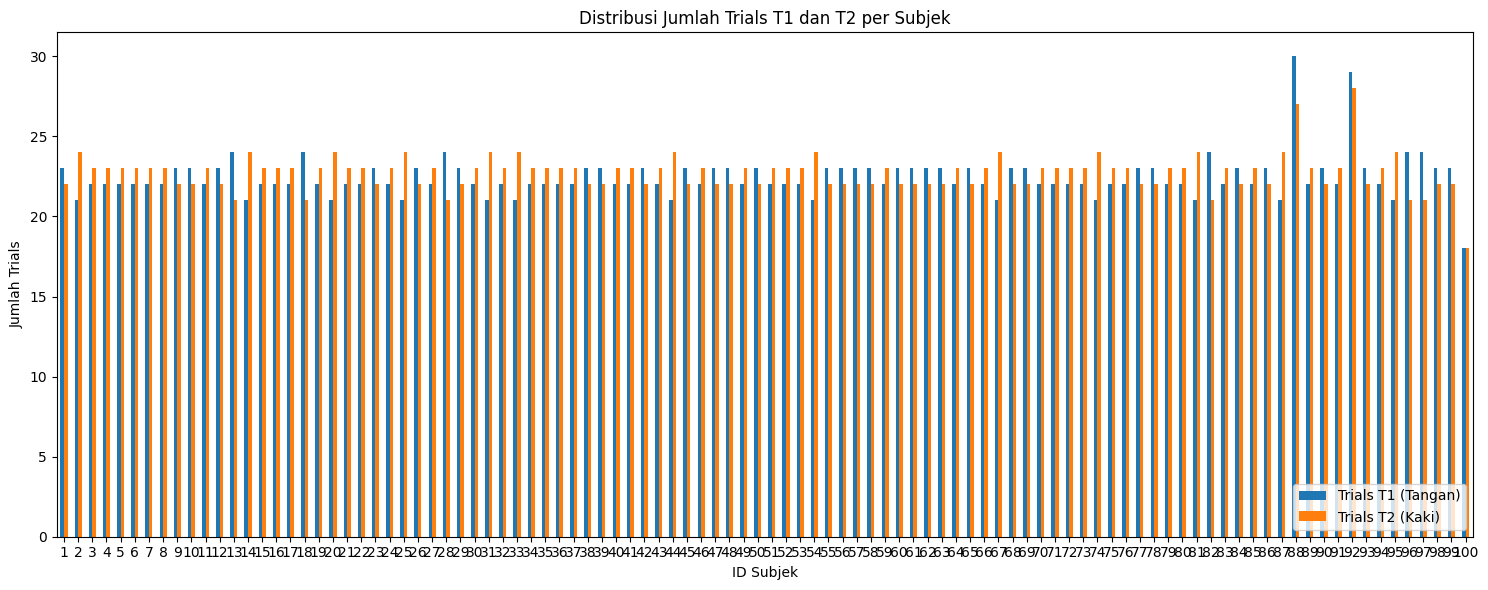

In [42]:
df_results = pd.DataFrame(all_subject_data).set_index('Subjek')

print("Tabel Ringkasan EDA untuk Subjek 1-15:")
display(df_results)

print("\n--- Analisis Konsistensi Data ---")

ok_subjects = df_results[df_results['Status'] == 'OK']

if not ok_subjects.empty:
    sfreq_konsisten = ok_subjects['Sampling Rate'].nunique() == 1
    sfreq_value = ok_subjects['Sampling Rate'].iloc[0]
    print(f"1. Sampling Rate: {'KONSISTEN' if sfreq_konsisten else 'TIDAK KONSISTEN'}")
    if sfreq_konsisten:
        print(f"   -> Semua subjek memiliki {sfreq_value} Hz.")

    ch_konsisten = ok_subjects['Jml Channel'].nunique() == 1
    ch_value = ok_subjects['Jml Channel'].iloc[0]
    print(f"2. Jml Channel:   {'KONSISTEN' if ch_konsisten else 'TIDAK KONSISTEN'}")
    if ch_konsisten:
        print(f"   -> Semua subjek memiliki {ch_value} channels.")

    ok_subjects['Imbalance'] = abs(ok_subjects['Trials T1 (Tangan)'] - ok_subjects['Trials T2 (Kaki)'])
    avg_imbalance = ok_subjects['Imbalance'].mean()
    print(f"3. Keseimbangan Label:")
    print(f"   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: {avg_imbalance:.2f} trials")
    print(f"   -> Subjek dengan imbalance > 2 trials:\n {ok_subjects[ok_subjects['Imbalance'] > 2][['Imbalance']]}")

else:
    print("Tidak ada data subjek yang berhasil diproses.")


print("\n--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---")

if not ok_subjects.empty:
    ax = ok_subjects[['Trials T1 (Tangan)', 'Trials T2 (Kaki)']].plot(
        kind='bar',
        stacked=False,
        figsize=(15, 6),
        rot=0,
        title='Distribusi Jumlah Trials T1 dan T2 per Subjek'
    )
    ax.set_xlabel("ID Subjek")
    ax.set_ylabel("Jumlah Trials")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [ ]:
def load_data(subject_ids):
    X_list = []
    y_list = []

    target_channels = ['C3..', 'Cz..', 'C4..']

    for subject_id in subject_ids:
        try:
            fnames = mne.datasets.eegbci.load_data(subject_id, RUNS, verbose=False)
            raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in fnames]
            raw = mne.io.concatenate_raws(raws, verbose=False)

            if raw.info['sfreq'] != FS:
                raw.resample(FS, verbose=False)

            raw.filter(1., 40., fir_design='firwin', skip_by_annotation='edge', verbose=False)

            raw.pick(target_channels, verbose=False)

            events, event_id_map = mne.events_from_annotations(raw, verbose=False)

            epochs = mne.Epochs(raw, events, event_id={'T1': 2, 'T2': 3},
                                tmin=T_MIN, tmax=T_MAX, baseline=None,
                                preload=True, verbose=False)

            data = epochs.get_data(copy=True) 

            if data.shape[2] != EPOCH_LENGTH:
                if data.shape[2] > EPOCH_LENGTH:
                    data = data[:, :, :EPOCH_LENGTH]
                else:
                    pad_width = EPOCH_LENGTH - data.shape[2]
                    data = np.pad(data, ((0,0), (0,0), (0, pad_width)), mode='edge')

            data = data * 1000

            labels = epochs.events[:, -1]
            labels = np.where(labels == 2, 0, 1)

            X_list.append(data)
            y_list.append(labels)

            if subject_id % 10 == 0:
                print(f"Processed Subject {subject_id}")

        except Exception as e:
            print(f"Skipping Subject {subject_id}: {e}")
            continue

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

print("Loading data... (Ini memakan waktu, tapi aman dari Error Dimensi)")
X_raw, y_raw = load_data(SUBJECT_IDS)
print(f"✅ Data Loaded. Shape: {X_raw.shape}") 

Loading data... (Ini memakan waktu, tapi aman dari Error Dimensi)
Processed Subject 10
Processed Subject 20
Processed Subject 30
Processed Subject 40
Processed Subject 50
Processed Subject 60
Processed Subject 70
Processed Subject 80
Processed Subject 90
Processed Subject 100
✅ Data Loaded. Shape: (4215, 3, 881)


In [ ]:
X_transposed = np.transpose(X_raw, (0, 2, 1))

X_final = X_transposed[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

print(f"Training Shape: {X_train.shape}")

Training Shape: (3372, 881, 3, 1)


In [ ]:
def build_pure_spatial_cnn(time_steps, nb_spatial_channels):
    model = Sequential()

    model.add(Input(shape=(time_steps, nb_spatial_channels, 1)))

    model.add(DepthwiseConv2D(
        kernel_size=(1, nb_spatial_channels), 
        depth_multiplier=8,                   
        padding='valid',                    
        depthwise_constraint=max_norm(1.),    
        use_bias=False
    ))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.25))


    model.add(SeparableConv2D(16, (32, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(AveragePooling2D(pool_size=(4, 1)))
    model.add(Dropout(0.25))

    model.add(SeparableConv2D(32, (16, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(AveragePooling2D(pool_size=(8, 1)))
    model.add(Dropout(0.25))

    model.add(Flatten()) 
    model.add(Dense(1, activation='sigmoid')) 

    return model

model = build_pure_spatial_cnn(time_steps=EPOCH_LENGTH, nb_spatial_channels=3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("✅ Model Pure 2D CNN Berhasil Dibangun")
model.summary()

✅ Model Pure 2D CNN Berhasil Dibangun


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d_4              │ (None, 881, 1, 8)      │            24 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 881, 1, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 881, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 881, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 881, 1, 16)     │           384 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 881, 1, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 881, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 220, 1, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 220, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 220, 1, 32)     │           768 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 220, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 220, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 27, 1, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 27, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265 (8.85 KB)

 Trainable params: 2,153 (8.41 KB)

 Non-trainable params: 112 (448.00 B)

In [ ]:
checkpoint_path = 'best_model_2d_cnn.keras'

checkpointer = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only=True,
    monitor='val_accuracy'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

my_callbacks = [checkpointer, reduce_lr, early_stop]

In [ ]:
print(f"\n{'='*40}")
print("🚀 MEMULAI TRAINING MODEL 2D CNN...")
print(f"{'='*40}")


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,            
    batch_size=32,         
    callbacks=my_callbacks, 
    verbose=1
)


🚀 MEMULAI TRAINING MODEL 2D CNN...
Epoch 1/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5385 - loss: 0.7253
Epoch 1: val_accuracy improved from -inf to 0.49229, saving model to best_model_2d_cnn.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5385 - loss: 0.7252 - val_accuracy: 0.4923 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/150
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5534 - loss: 0.6871
Epoch 2: val_accuracy improved from 0.49229 to 0.50059, saving model to best_model_2d_cnn.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5535 - loss: 0.6872 - val_accuracy: 0.5006 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/150
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5842 - loss: 0.6721
Epoch 3: val_accuracy improved from 0.50059 to 0.52076, saving model to best_model_2d_cnn.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5844 - loss: 0.6721 - val_accuracy: 0.5208 - val_loss: 0.6903 - learning_rate


📊 HASIL EVALUASI MODEL
🏆 Test Accuracy : 74.73%
📉 Test Loss     : 0.5191
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


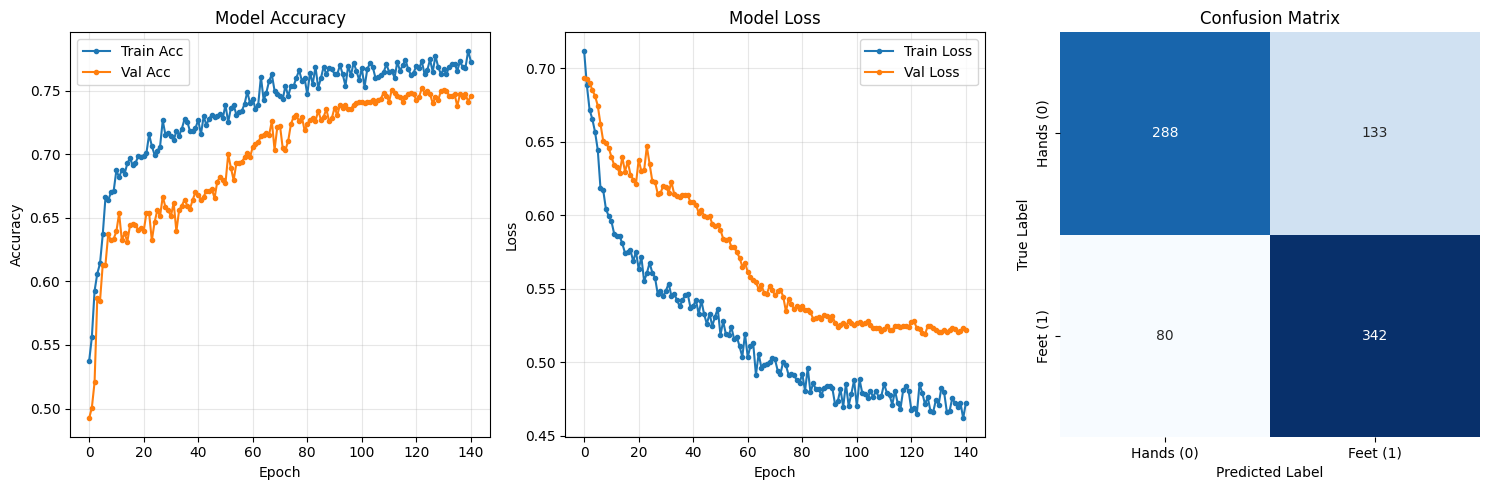


📋 DETAIL KLASIFIKASI
              precision    recall  f1-score   support

   Hands (0)       0.78      0.68      0.73       421
    Feet (1)       0.72      0.81      0.76       422

    accuracy                           0.75       843
   macro avg       0.75      0.75      0.75       843
weighted avg       0.75      0.75      0.75       843



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print(f"\n{'='*40}")
print("📊 HASIL EVALUASI MODEL")
print(f"{'='*40}")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🏆 Test Accuracy : {acc*100:.2f}%")
print(f"📉 Test Loss     : {loss:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='.')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='.')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='.')
plt.plot(history.history['val_loss'], label='Val Loss', marker='.')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Hands (0)', 'Feet (1)'],
            yticklabels=['Hands (0)', 'Feet (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

print(f"\n{'='*40}")
print("📋 DETAIL KLASIFIKASI")
print(f"{'='*40}")
print(classification_report(y_test, y_pred, target_names=['Hands (0)', 'Feet (1)']))

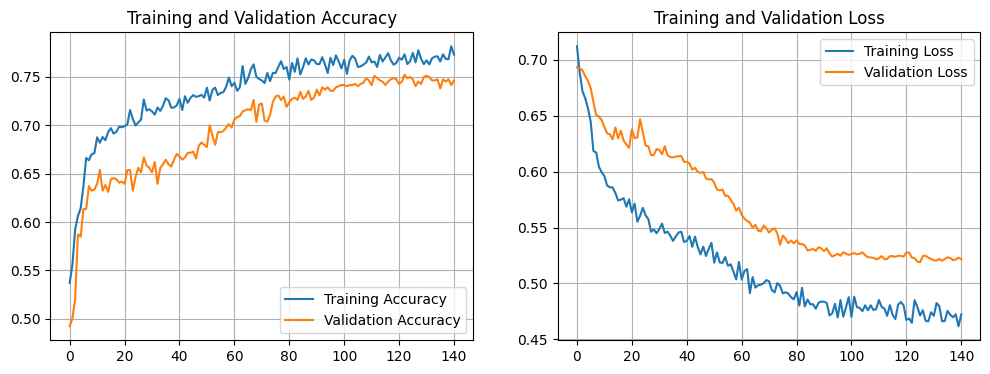

✅ Training Selesai. Model terbaik disimpan di: best_model_2d_cnn.keras


In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

plot_history(history)

print(f"✅ Training Selesai. Model terbaik disimpan di: {checkpoint_path}")